In [ ]:
import numpy as np
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch
from torch.utils.data import DataLoader

from torchvision import models
from torchvision.transforms import InterpolationMode
from dataset import FSPairedDataset
from model.Encoder import Encoder

In [ ]:
# check target feature size
target_f = torch.load("./data/real_pic/00000/features.pt")
z = target_f['z']
ws = target_f['ws']
tri_plane = target_f['tri_plane']

# print size
print(f"z size: {z.shape}")
print(f"ws size: {ws.shape}")
print(f"tri_plane size: {tri_plane.shape}")


# Check Camera Pose

In [ ]:
import torch 
camera = torch.load('./data/real_pic/00000/camera_angle.pt')
camera[0]

# Generate Real Picture w/ Embedded ws and tri-plane

In [2]:
import os
import re
from typing import List, Optional, Tuple, Union
import sys
sys.path.append('../PanoHead')

import click
import dnnlib
import numpy as np
import PIL.Image
import torch
from tqdm import tqdm
import mrcfile
import matplotlib.pyplot as plt

import random
import legacy
from camera_utils import LookAtPoseSampler, FOV_to_intrinsics
from torch_utils import misc
from training.triplane import TriPlaneGenerator
import torchvision.transforms as transforms

from model.Encoder import Encoder
from PIL import Image

In [74]:
# load PanoHead Model and single sketch image
def generate_images(
    network_pkl: str,
    seed: int,
    truncation_psi: float,
    truncation_cutoff: int,
    outdir: str,
    shapes: bool,
    shape_res: int,
    fov_deg: float,
    shape_format: str,
    class_idx: Optional[int],
    reload_modules: bool,
    pose_cond: int,
    ws
):
    """Generate images using pretrained network pickle.

    Examples:

    \b
    # Generate an image using pre-trained model.
    python gen_samples.py --outdir=out --trunc=0.7 --shapes=true --seeds=0-3 \
        --network models/easy-khair-180-gpc0.8-trans10-025000.pkl
    """
    
    print('Loading networks from "%s"...' % network_pkl)
    device = torch.device('cuda:0')
    with dnnlib.util.open_url(network_pkl) as f:
        G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

    # Specify reload_modules=True if you want code modifications to take effect; otherwise uses pickled code
    if reload_modules:
        print("Reloading Modules!")
        G_new = TriPlaneGenerator(*G.init_args, **G.init_kwargs).eval().requires_grad_(False).to(device)
        misc.copy_params_and_buffers(G, G_new, require_all=True)
        G_new.neural_rendering_resolution = G.neural_rendering_resolution
        G_new.rendering_kwargs = G.rendering_kwargs
        G = G_new

    network_pkl = os.path.basename(network_pkl)
    # outdir = os.path.join(outdir, os.path.splitext(network_pkl)[0] + '_' + str(pose_cond))
    os.makedirs(outdir, exist_ok=True)

    pose_cond_rad = pose_cond/180*np.pi
    intrinsics = FOV_to_intrinsics(fov_deg, device=device)

    # cond camera settings
    cam_pivot = torch.tensor([0, 0, 0], device=device)
    cam_radius = G.rendering_kwargs.get('avg_camera_radius', 2.7)
    conditioning_cam2world_pose = LookAtPoseSampler.sample(pose_cond_rad, np.pi/2, cam_pivot, radius=cam_radius, device=device)
    conditioning_params = torch.cat([conditioning_cam2world_pose.reshape(-1, 16), intrinsics.reshape(-1, 9)], 1)

    imgs = []
    # angle_p = -0.2
    # angle_p = -90/180*np.pi
    # for angle_y, angle_p in [(2.1, angle_p), (1.05, angle_p), (0, angle_p), (-1.05, angle_p), (-2.1, angle_p)]:

    # random sampling camera angle (range: +90~-90(left-right), +20~-20(up-down))
    # num_samples = 10
    # angle_y = [random.uniform(-90, 90) for _ in range(num_samples)]
    # angle_p = [random.uniform(-20, 20) for _ in range(num_samples)]
    # camera_angle = [(yaw/180*np.pi, pitch/180*np.pi) for yaw, pitch in zip(angle_y, angle_p)]
    # breakpoint()
    camera_angle = torch.load(f'./data/real_pic/{seed:05d}/camera_angle.pt')
    camera_angle = [angle for angle in camera_angle.values()]

    # make output folder
    output_folder = f'./output/{seed:05d}'
    os.makedirs(output_folder, exist_ok= True)

    for idx, angles in enumerate(camera_angle):
        # idx 
        # 0: front |1: left 45deg |2: left 90deg |3: left 135deg |4: left 180deg |5: right 135deg |6: right 90deg |7: right 45deg
        # make dir for each image (z, w, tri-plane feature)
        
        # random.seed(seed)
        # np.random.seed(seed)
        # torch.manual_seed(seed)
        # torch.cuda.manual_seed_all(seed)

        angle_y = angles[0]
        angle_p = angles[1]
        # rand camera setting
        cam2world_pose = LookAtPoseSampler.sample(np.pi/2 + angle_y, np.pi/2 + angle_p, cam_pivot, radius=cam_radius, device=device)
        camera_params = torch.cat([cam2world_pose.reshape(-1, 16), intrinsics.reshape(-1, 9)], 1)

        # img = G.synthesis(ws, camera_params, ws_bcg = ws_list[idx])['image']
        img = G.synthesis(ws, camera_params)['image']
    
        # z, ws, triplane save for each seed
        
        # img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
        # print(F'Img Max: {img.max()}, Img Min: {img.min()}')
        img = (img - img.min()) / (img.max()-img.min())
        # img = img * 255

        img = img.permute(0, 2, 3, 1).squeeze() * 255
        img = img.detach().cpu().numpy()
        print(F'Img Max: {img.max()}, Img Min: {img.min()}')
        PIL.Image.fromarray(img.squeeze(), 'RGB').save(output_folder + f'/{seed:05d}-{idx}_recon.png')


In [27]:
# load ws encoder 
target = 'ws'
device = 'cuda'
encoder_path = './checkpoints/ws_psp_v2/ws_encoder_epoch_7|10_minibatch_300|625.pt'

net = Encoder(target).to(device)
net.load_state_dict(torch.load(encoder_path))


<All keys matched successfully>

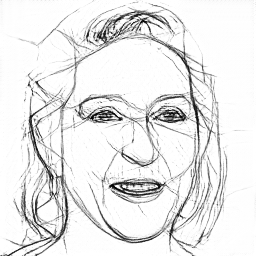

In [28]:
# set seed
seed = 202
sketch_image_path = f'./data/sketch/{seed:05d}/{seed:05d}-8.png'
img = Image.open(sketch_image_path).convert('RGB')
img.show()


In [29]:
# inference of sketch image to get ws_hat
img_tensor = transforms.ToTensor()(img).cuda()
img_tensor = img_tensor.unsqueeze(dim = 0)

ws_hat = net(img_tensor)
ws_hat.shape

torch.Size([1, 14, 512])

In [75]:
# inference of ws to get real pic
args = {
    "network_pkl": '../PanoHead/models/easy-khair-180-gpc0.8-trans10-025000.pkl',
    "seed": seed,
    "truncation_psi": 0.7,
    "truncation_cutoff": 14,
    "outdir": "output",
    "shapes": False,
    "shape_res": 512,
    "fov_deg": 18.837,
    "shape_format": '.mrc',
    "class_idx": None,
    "reload_modules": True,
    "pose_cond": 90,
    "ws": ws_hat
}
generate_images(**args)

Loading networks from "../PanoHead/models/easy-khair-180-gpc0.8-trans10-025000.pkl"...
Reloading Modules!
Img Max: 255.0, Img Min: 0.0
Img Max: 255.0, Img Min: 0.0
Img Max: 255.0, Img Min: 0.0
Img Max: 255.0, Img Min: 0.0
Img Max: 255.0, Img Min: 0.0
Img Max: 255.0, Img Min: 0.0
Img Max: 255.0, Img Min: 0.0
Img Max: 255.0, Img Min: 0.0
Img Max: 255.0, Img Min: 0.0
Img Max: 255.0, Img Min: 0.0


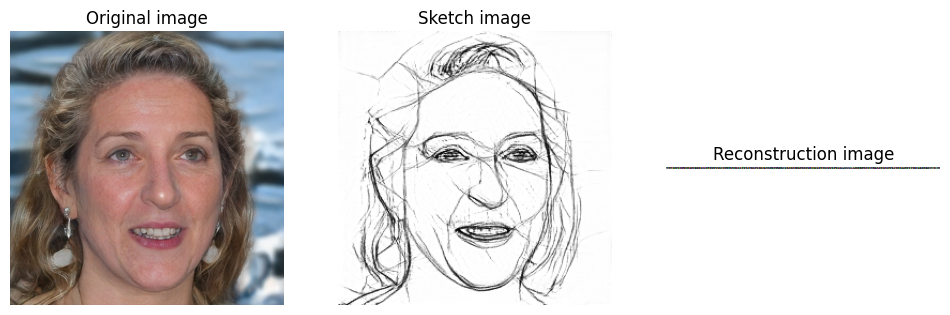

In [76]:
og_image = Image.open(f"./data/real_pic/{seed:05d}/{seed:05d}-8.png")
sketch_image = Image.open(f"./data/sketch/{seed:05d}/{seed:05d}-8.png")
recon_image = Image.open(f"./output/{seed:05d}/{seed:05d}-8_recon.png")

fig, axs = plt.subplots(1, 3, figsize=(12, 6))

axs[0].imshow(og_image)
axs[0].set_title("Original image")
axs[0].axis('off')

axs[1].imshow(sketch_image)
axs[1].set_title("Sketch image")
axs[1].axis('off')

axs[2].imshow(recon_image)
axs[2].set_title("Reconstruction image")
axs[2].axis('off')

plt.show()

In [36]:
import random
import math

pi = torch.tensor(math.pi, dtype=torch.float32)
class MyClass:
    def resize(self, tensor, scale):
        resize_matrix = torch.tensor([[scale, 0],
                                    [0, scale]]).to(torch.float32)
        return torch.matmul(tensor, resize_matrix)
    
    def flip(self, tensor, axis='x'):
        if axis == 'x':
            flip_matrix = torch.tensor([[1, 0],
                                        [0, -1]]).to(torch.float32)
        elif axis == 'y':
            flip_matrix = torch.tensor([[-1, 0],
                                        [0, 1]]).to(torch.float32)
        return torch.matmul(tensor, flip_matrix)
    
    def rotate(self, tensor, angle_degrees):
        angle_radians = torch.tensor(angle_degrees, dtype=torch.float32) * (pi / 180)
        rotate_matrix = torch.tensor([[torch.cos(angle_radians), -torch.sin(angle_radians)],
                                    [torch.sin(angle_radians), torch.cos(angle_radians)]]).to(torch.float32)
        return torch.matmul(tensor, rotate_matrix)

    def transform_func(self,tensor):
        transform_funcs = [self.resize, self.flip, self.rotate]
        
        # 리스트에서 무작위로 메서드 선택
        selected_method = random.choice(transform_funcs)
        if selected_method == self.resize:
            return selected_method(tensor, 0.5), selected_method
        if selected_method == self.flip:
            return selected_method(tensor), selected_method
        if selected_method == self.rotate:
            return selected_method(tensor, 3.14), selected_method
        # 선택된 메서드 실행 및 결과 반환


In [19]:
import torch

In [58]:
# 클래스 인스턴스 생성
my_instance = MyClass()
tensor = torch.rand(128,4,2)
# 랜덤 메서드 실행
result, method = my_instance.transform_func(tensor)
result.shape, method.__name__


(torch.Size([128, 4, 2]), 'rotate')